In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass

from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import log_loss, roc_auc_score

Data loaded
Shape: (10000, 8)
FICO range: 408 – 850
Overall default rate: 18.51%



,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


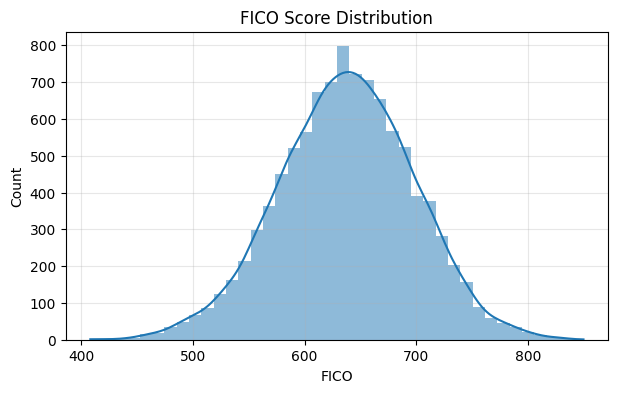

In [2]:
# Load the data you provided
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

df = pd.read_csv("Loan_Data.csv") 
assert "fico_score" in df.columns and "default" in df.columns, "Need fico_score and default columns."

print("Data loaded")
print(f"Shape: {df.shape}")
print(f"FICO range: {df['fico_score'].min()} – {df['fico_score'].max()}")
print(f"Overall default rate: {df['default'].mean():.2%}\n")

display(df.head())

# Quick FICO distribution visual
plt.figure(figsize=(7,4))
sns.histplot(df["fico_score"], bins=40, kde=True, edgecolor="none")
plt.title("FICO Score Distribution")
plt.xlabel("FICO")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()

In [3]:
# Helpers — aggregation, costs, DP segmentation
def aggregate_by_score(data: pd.DataFrame) -> pd.DataFrame:
    """
    Collapse to unique fico_score rows to speed up DP and allow min_bin by counts.
    Returns dataframe g with columns:
      score (ascending), n (#obs), k (#defaults),
      cumN, cumK, cumX (score*count), cumXX (score^2*count)
    """
    g = (data
         .groupby("fico_score", as_index=False)["default"]
         .agg(n="size", k="sum")
         .sort_values("fico_score")
         .reset_index(drop=True))
    g.rename(columns={"fico_score": "score"}, inplace=True)
    # weighted sums for MSE cost
    g["xw"] = g["score"] * g["n"]
    g["xxw"] = (g["score"]**2) * g["n"]
    # prefix sums (1-index style will be easier in DP)
    g["cumN"]  = g["n"].cumsum()
    g["cumK"]  = g["k"].cumsum()
    g["cumX"]  = g["xw"].cumsum()
    g["cumXX"] = g["xxw"].cumsum()
    return g

def _segment_sums(g: pd.DataFrame, a: int, b: int) -> Tuple[float,float,float,float]:
    """
    Inclusive segment [a..b], 1-indexed.
    Returns (n, k, sumX, sumXX) for that segment.
    """
    if a == 1:
        n  = g.loc[b-1, "cumN"]
        k  = g.loc[b-1, "cumK"]
        x  = g.loc[b-1, "cumX"]
        xx = g.loc[b-1, "cumXX"]
    else:
        n  = g.loc[b-1, "cumN"]  - g.loc[a-2, "cumN"]
        k  = g.loc[b-1, "cumK"]  - g.loc[a-2, "cumK"]
        x  = g.loc[b-1, "cumX"]  - g.loc[a-2, "cumX"]
        xx = g.loc[b-1, "cumXX"] - g.loc[a-2, "cumXX"]
    return float(n), float(k), float(x), float(xx)

def _cost_mse(g: pd.DataFrame, a: int, b: int) -> float:
    """
    Weighted SSE cost for scores in [a..b] (1-indexed, inclusive).
    """
    n, _, x, xx = _segment_sums(g, a, b)
    if n <= 0: 
        return np.inf
    # SSE = sum((x - mean)^2) weighted by counts = sumxx - sumx^2 / n
    return xx - (x*x)/n

def _cost_loglik(g: pd.DataFrame, a: int, b: int, alpha: float = 1.0) -> float:
    """
    Negative log-likelihood cost with Laplace smoothing on p.
    p = (k+alpha)/(n+2alpha).
    """
    n, k, _, _ = _segment_sums(g, a, b)
    if n <= 0: 
        return np.inf
    p = (k + alpha) / (n + 2*alpha)
    # guardrails
    p = np.clip(p, 1e-12, 1-1e-12)
    return -(k*np.log(p) + (n - k)*np.log(1 - p))


In [4]:
def dp_segment(g: pd.DataFrame, K: int, objective: str = "mse", min_bin: int = 100, alpha: float = 1.0) -> Optional[List[int]]:
    """
    1-D dynamic programming segmentation on unique-score grid.
    Returns cut indices (endpoints of first K-1 segments), 1-indexed on g rows.
      - g has m rows (unique scores sorted).
      - We segment those m rows into K contiguous segments.
      - Enforce each segment has total n >= min_bin.

    Output: list of "end indices" for the first K-1 segments, e.g. [j1, j2, ..., j_{K-1}]
    """
    m = len(g)
    if K <= 0 or m <= 0: 
        return None
    # Feasibility check for min_bin
    if g["cumN"].iloc[-1] < K * min_bin:
        return None

    # DP tables
    DP = np.full((K+1, m+1), np.inf)   # DP[k][j] => min cost to cover first j pts with k buckets
    BK = np.full((K+1, m+1), -1, dtype=int)

    DP[0,0] = 0.0
    # precompute feasible segment starts for speed? (we'll loop; m ~ few hundred)
    for k in range(1, K+1):
        # smallest j so that at least k segments each with min_bin can exist:
        j_min = k  # index-wise start; count constraint handled below
        for j in range(j_min, m+1):
            best_cost = np.inf
            best_i = -1
            # try previous break at i (so current segment is [i+1..j])
            # ensure segment [i+1..j] has enough observations
            # also ensure the leftover (first i points for k-1 segments) was feasible
            for i in range(k-1, j):
                # check min_bin for current piece
                n_seg, *_ = _segment_sums(g, i+1, j)
                if n_seg < min_bin:
                    continue
                cost_piece = _cost_mse(g, i+1, j) if objective == "mse" else _cost_loglik(g, i+1, j, alpha=alpha)
                cand = DP[k-1, i] + cost_piece
                if cand < best_cost:
                    best_cost = cand
                    best_i = i
            DP[k, j] = best_cost
            BK[k, j] = best_i

    if not np.isfinite(DP[K, m]):
        return None

    # backtrack to get cut ends (for the first K-1 segments)
    cuts = []
    k, j = K, m
    while k > 0:
        i = BK[k, j]
        if i < 0:
            break
        # current segment = (i+1..j)
        cuts.append(j)   # store end index of this segment
        j = i
        k -= 1
    cuts.reverse()
    # we stored end index for all segments (K of them); we want ONLY first K-1 as boundaries
    if len(cuts) == K:
        cuts = cuts[:-1]
    return cuts

In [5]:
def indices_to_boundaries(g: pd.DataFrame, cuts: List[int]) -> List[float]:
    """
    Convert cut indices on the unique-score grid into numeric boundaries
    for pd.cut(..., right=False, include_lowest=True).
    Strategy:
      - leftmost boundary = min score
      - for each cut index j (segment ends at row j), boundary is next score's value
        so previous bin is [prev_left, boundary)
      - last boundary = max score + tiny epsilon (so right-open covers max)
    """
    scores = g["score"].to_numpy()
    m = len(scores)
    eps = 1e-6
    boundaries = [float(scores[0])]
    for j in cuts:
        if j < m:
            boundaries.append(float(scores[j])) if False else boundaries.append(float(scores[j] + 1e-6))
            # Slightly safer to start next bin at the next integer score;
            # but using a tiny epsilon also works with right=False.
            # To be crisp with integer FICOs: use next score as hard boundary:
            # boundaries.append(float(scores[j] + 1))
    boundaries.append(float(scores[-1] + 1))  # ensure we include the max in the last open interval
    # sanitize monotonicity
    boundaries = np.unique(np.array(boundaries, dtype=float))
    return boundaries.tolist()

def equal_width_boundaries(data: pd.DataFrame, K: int) -> List[float]:
    lo, hi = data["fico_score"].min(), data["fico_score"].max()
    edges = np.linspace(lo, hi, K+1).astype(float)
    edges[-1] = hi + 1  # make last open interval include max
    return edges.tolist()

def equal_freq_boundaries(data: pd.DataFrame, K: int) -> List[float]:
    """
    Quantile-based. Duplicates can occur with discrete FICO; we uniquify and keep last boundary > max.
    """
    q = np.linspace(0, 1, K+1)
    edges = data["fico_score"].quantile(q).to_numpy(dtype=float)
    edges = np.unique(edges)
    if edges[-1] <= data["fico_score"].max():
        edges = np.append(edges, data["fico_score"].max() + 1.0)
    return edges.tolist()

In [6]:
# Fit per-bucket PDs (Laplace) + enforce monotonic
def fit_bucket_pd(train_df: pd.DataFrame, boundaries: List[float], alpha: float = 1.0) -> Tuple[pd.DataFrame, np.ndarray]:
    """
    Build per-bucket PDs (Laplace-smoothed) and enforce monotone PD (higher FICO -> lower PD).
    Returns (bucket_table, pd_mono_vector in bucket order).
    """
    # Bin the FICO scores into the provided boundaries
    cats = pd.cut(train_df["fico_score"], bins=boundaries, right=False, include_lowest=True)

    # Aggregate counts & defaults by bin (observed=True => ignore empty categories)
    grp = (
        train_df
        .groupby(cats, observed=True)["default"]
        .agg(n="size", k="sum")
        .reset_index()
    )

    # normalize the interval column name
    bin_col = grp.columns[0]
    grp = grp.rename(columns={bin_col: "bin"})
    grp["lower"] = grp["bin"].apply(lambda iv: float(iv.left))
    grp["upper"] = grp["bin"].apply(lambda iv: float(iv.right))

    # Laplace-smoothed PD per bucket
    grp["pd_raw"] = (grp["k"] + alpha) / (grp["n"] + 2 * alpha)

    # Isotonic regression: decreasing PD with higher FICO (use bucket centers)
    centers = (grp["lower"].to_numpy() + grp["upper"].to_numpy()) / 2.0
    y = grp["pd_raw"].to_numpy()
    w = grp["n"].to_numpy()

    order = np.argsort(centers)
    x_sorted = centers[order]
    y_sorted = y[order]
    w_sorted = w[order]

    iso = IsotonicRegression(increasing=False, out_of_bounds="clip")
    iso.fit(x_sorted, y_sorted, sample_weight=w_sorted)
    pd_mono_sorted = iso.predict(x_sorted)

    pd_mono = np.empty_like(pd_mono_sorted)
    pd_mono[order] = pd_mono_sorted

    grp["pd_mono"] = pd_mono
    grp["bucket_id"] = np.arange(1, len(grp) + 1)

    return grp, pd_mono

def predict_pd_from_buckets(scores: np.ndarray, boundaries: List[float], pd_mono: np.ndarray) -> np.ndarray:
    """
    Vectorized mapping from fico_score -> predicted PD via bucket index.
    """
    edges = np.array(boundaries, dtype=float)
    # index of the bucket is searchsorted(right=False) - 1
    idx = np.searchsorted(edges, scores.astype(float), side="right") - 1
    idx = np.clip(idx, 0, len(pd_mono) - 1)
    return pd_mono[idx]

In [7]:
# Evaluate a boundary set on valid split
def eval_bucketing(train_df: pd.DataFrame, valid_df: pd.DataFrame, boundaries: List[float], alpha: float = 1.0) -> Dict[str, float]:
    bucket_df, pd_mono = fit_bucket_pd(train_df, boundaries, alpha=alpha)
    y_true = valid_df["default"].values
    y_pred = predict_pd_from_buckets(valid_df["fico_score"].values, boundaries, pd_mono)
    y_pred = np.clip(y_pred, 1e-8, 1-1e-8)
    return {
        "logloss": float(log_loss(y_true, y_pred)),
        "auc": float(roc_auc_score(y_true, y_pred)),
        "bucket_table": bucket_df
    }

def method_boundaries(method: str, K: int, train_df: pd.DataFrame, g: pd.DataFrame, min_bin: int, alpha: float) -> Optional[List[float]]:
    if method == "Equal-Width":
        return equal_width_boundaries(train_df, K)
    elif method == "Equal-Frequency":
        return equal_freq_boundaries(train_df, K)
    elif method == "DP-MSE":
        cuts = dp_segment(g, K, objective="mse",    min_bin=min_bin, alpha=alpha)
        return indices_to_boundaries(g, cuts) if cuts else None
    elif method == "DP-LogLik":
        cuts = dp_segment(g, K, objective="loglik", min_bin=min_bin, alpha=alpha)
        return indices_to_boundaries(g, cuts) if cuts else None
    else:
        raise ValueError("Unknown method")

In [8]:
# Train/valid split & model selection over K,method
print("\nSplitting data into train/valid for boundary selection...")
work = df[["fico_score","default"]].dropna().copy()
train_df, valid_df = train_test_split(
    work, test_size=0.30, random_state=RANDOM_STATE, stratify=work["default"]
)
print(f"Train: {train_df.shape}, Valid: {valid_df.shape} | "
      f"default rate train={train_df['default'].mean():.2%}, valid={valid_df['default'].mean():.2%}")

g_train = aggregate_by_score(train_df)

methods = ["Equal-Width", "Equal-Frequency", "DP-MSE", "DP-LogLik"]
K_grid   = [4,5,6,7,8,10]
alpha    = 1.0     # Laplace smoothing in likelihood + per-bucket PD
min_bin  = 100     # min observations per bucket (on train) for DP methods

rows = []
best = None

print("\nSearching for good bucketings… (this is quick)")
for method in methods:
    for K in K_grid:
        b = method_boundaries(method, K, train_df, g_train, min_bin, alpha)
        if b is None or len(b) < 2:
            # infeasible (e.g., min_bin too strict for K), skip
            continue
        res = eval_bucketing(train_df, valid_df, b, alpha=alpha)
        rows.append({
            "Method": method, "K": K,
            "LogLoss": res["logloss"], "AUC": res["auc"],
            "Boundaries": b, "BucketTable": res["bucket_table"]
        })
        if (best is None) or (res["logloss"] < best["LogLoss"] - 1e-12):
            best = {
                "Method": method, "K": K,
                "LogLoss": res["logloss"], "AUC": res["auc"],
                "Boundaries": b, "BucketTable": res["bucket_table"]
            }

summary = pd.DataFrame(
    [{k:v for k,v in r.items() if k in ["Method","K","LogLoss","AUC"]} for r in rows]
).sort_values(["LogLoss","Method","K"]).reset_index(drop=True)

print("\n==============================")
print("MODEL SELECTION SUMMARY (Valid)")
print("==============================")
try:
    display(summary.head(12))
except NameError:
    print(summary.head(12).to_string(index=False))

print("\n====================")
print("BEST BUCKETING PICK")
print("====================")
print(f"Method:   {best['Method']}")
print(f"K:        {best['K']}")
print(f"LogLoss:  {best['LogLoss']:.6f}")
print(f"AUC:      {best['AUC']:.6f}")
print("Boundaries:")
print([round(x,3) for x in best["Boundaries"]])



Splitting data into train/valid for boundary selection...
Train: (7000, 2), Valid: (3000, 2) | default rate train=18.51%, valid=18.50%

Searching for good bucketings… (this is quick)


KeyboardInterrupt: 


Bucket table (best pick):


,bucket_id,lower,upper,n,k,pd_raw,pd_mono,default_rate_%
0,1,409.0,453.1,9,6,0.636364,0.691148,69.11
1,2,453.1,497.2,100,70,0.696078,0.691148,69.11
2,3,497.2,541.3,317,165,0.520376,0.520376,52.04
3,4,541.3,585.4,955,340,0.356322,0.356322,35.63
4,5,585.4,629.5,1705,340,0.199766,0.199766,19.98
5,6,629.5,673.6,1972,254,0.129179,0.129179,12.92
6,7,673.6,717.7,1286,100,0.078416,0.078416,7.84
7,8,717.7,761.8,517,18,0.036609,0.036609,3.66
8,9,761.8,805.9,121,2,0.024390,0.034181,3.42
9,10,805.9,851.0,18,1,0.100000,0.034181,3.42


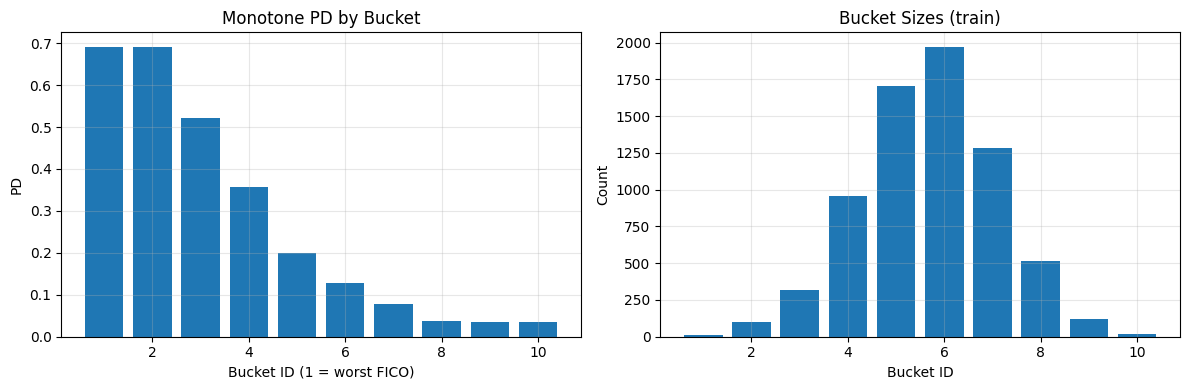

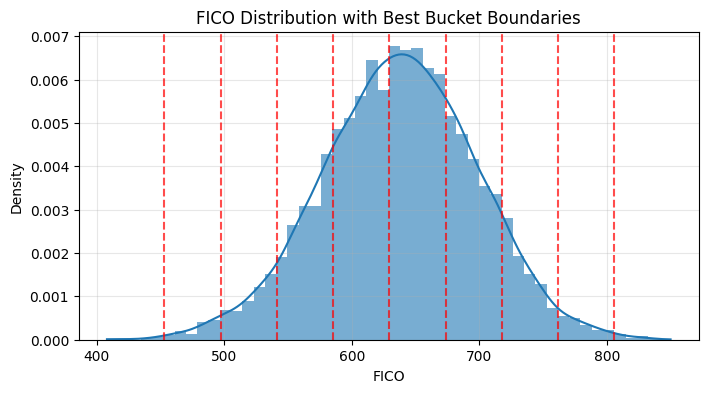

In [9]:
# Inspect the best buckets (counts, PDs, visuals)
best_tbl = best["BucketTable"].copy()
best_tbl["default_rate_%"] = (best_tbl["pd_mono"] * 100).round(2)

print("\nBucket table (best pick):")
display(best_tbl[["bucket_id","lower","upper","n","k","pd_raw","pd_mono","default_rate_%"]])

# Visuals: default rate by bucket + counts
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].bar(best_tbl["bucket_id"], best_tbl["pd_mono"])
axes[0].set_title("Monotone PD by Bucket")
axes[0].set_xlabel("Bucket ID (1 = worst FICO)")
axes[0].set_ylabel("PD")
axes[0].grid(alpha=0.3)

axes[1].bar(best_tbl["bucket_id"], best_tbl["n"])
axes[1].set_title("Bucket Sizes (train)")
axes[1].set_xlabel("Bucket ID")
axes[1].set_ylabel("Count")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Overlay boundaries on full FICO distribution
plt.figure(figsize=(8,4))
sns.histplot(work["fico_score"], bins=50, kde=True, stat="density", edgecolor="none", alpha=0.6)
for b in best["Boundaries"][1:-1]:
    plt.axvline(b, color="red", linestyle="--", alpha=0.7)
plt.title("FICO Distribution with Best Bucket Boundaries")
plt.xlabel("FICO")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.show()

In [10]:
# Create a Rating Map (lower rating = better credit)
def rating_labels(n_buckets: int) -> List[str]:
    """
    Human-friendly labels (AAA best) if <=7 buckets, else numeric.
    We number from best FICO (last bucket) downward so lower label ⇒ better credit.
    """
    if n_buckets <= 5:
        labels = ["A","B","C","D","E"]       # A best
    elif n_buckets <= 7:
        labels = ["AAA","AA","A","BBB","BB","B","C"]  # AAA best
    else:
        # more buckets → numeric grades
        labels = [f"Grade_{i}" for i in range(1, n_buckets+1)]  # Grade_1 best
    # reverse so the last bucket (highest FICO) gets the first/best label
    return list(reversed(labels[:n_buckets]))

def build_rating_map(boundaries: List[float]) -> Dict[str, Tuple[float, float]]:
    bucket_count = len(boundaries) - 1
    labels = rating_labels(bucket_count)
    mapping = {}
    for i in range(bucket_count):
        lo, hi = boundaries[i], boundaries[i+1]
        mapping[labels[i]] = (lo, hi)
    return mapping

rating_map = build_rating_map(best["Boundaries"])
print("\nRATING MAP (lower rating label = better credit)")
for k, (lo, hi) in rating_map.items():
    print(f"{k:>7s}: [{lo:.0f}, {hi:.0f})")



RATING MAP (lower rating label = better credit)
Grade_10: [409, 453)
Grade_9: [453, 497)
Grade_8: [497, 541)
Grade_7: [541, 585)
Grade_6: [585, 630)
Grade_5: [630, 674)
Grade_4: [674, 718)
Grade_3: [718, 762)
Grade_2: [762, 806)
Grade_1: [806, 851)



Head of scored dataset (FICO → PD):


,fico_score,default,pd_best
0,605,0,0.199766
1,572,1,0.356322
2,602,0,0.199766
3,612,0,0.199766
4,631,0,0.129179
5,697,0,0.078416
6,722,0,0.036609
7,545,1,0.356322
8,676,0,0.078416
9,447,0,0.691148



PD summary over ALL records:


,count,mean,std,min,10%,25%,50%,75%,90%,95%,max
pd_best,10000.0,0.184681,0.132492,0.034181,0.078416,0.078416,0.129179,0.199766,0.356322,0.520376,0.691148


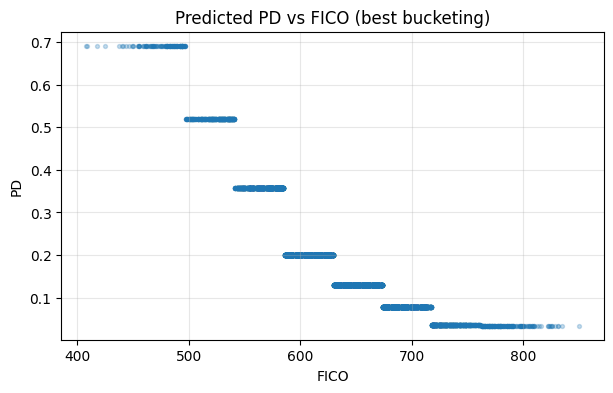

In [11]:
# Score the *entire* book with the best buckets
full_bucket_tbl, full_pd = fit_bucket_pd(train_df, best["Boundaries"], alpha=alpha)
# Use those same bucket PDs to score ALL records (train+valid)
pd_all = predict_pd_from_buckets(work["fico_score"].values, best["Boundaries"], full_bucket_tbl["pd_mono"].values)

scored = work.copy()
scored["pd_best"] = pd_all

print("\nHead of scored dataset (FICO → PD):")
display(scored.head(10))

print("\nPD summary over ALL records:")
display(scored["pd_best"].describe(percentiles=[.1,.25,.5,.75,.9,.95]).to_frame().T)

# Optional: show PD vs FICO scatter (thin alpha)
plt.figure(figsize=(7,4))
plt.scatter(scored["fico_score"], scored["pd_best"], s=8, alpha=0.25)
plt.title("Predicted PD vs FICO (best bucketing)")
plt.xlabel("FICO")
plt.ylabel("PD")
plt.grid(alpha=0.3)
plt.show()

In [12]:
# Sanity check: validation logloss and AUC using the *best* buckets
final_eval = eval_bucketing(train_df, valid_df, best["Boundaries"], alpha=alpha)
print("\nFinal check on validation with the chosen boundaries:")
print(f"LogLoss: {final_eval['logloss']:.6f} | AUC: {final_eval['auc']:.6f}")

# Simple function to assign *rating label* to any FICO
def assign_rating_from_map(fico: float, boundaries: List[float]) -> str:
    labels = rating_labels(len(boundaries)-1)
    # left-closed right-open bins; last includes max
    idx = np.searchsorted(np.array(boundaries), fico, side="right") - 1
    idx = int(np.clip(idx, 0, len(labels)-1))
    return labels[idx]

# Demo: assign ratings to a few FICOs
samples = [520, 600, 650, 700, 740, 800]
print("\nRating assignment demo:")
for s in samples:
    print(f"FICO {s}: {assign_rating_from_map(s, best['Boundaries'])}")


Final check on validation with the chosen boundaries:
LogLoss: 0.434131 | AUC: 0.703578

Rating assignment demo:
FICO 520: Grade_8
FICO 600: Grade_6
FICO 650: Grade_5
FICO 700: Grade_4
FICO 740: Grade_3
FICO 800: Grade_2


KS (valid): 0.303


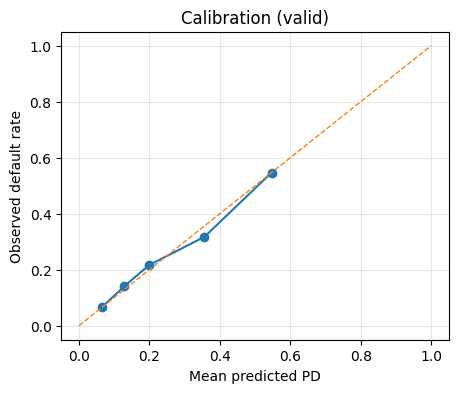

In [13]:
# KS and simple calibration diagnostics on VALID
from sklearn.calibration import calibration_curve

y_true = valid_df["default"].values
y_pred = predict_pd_from_buckets(valid_df["fico_score"].values, best["Boundaries"], 
                                 best["BucketTable"]["pd_mono"].values)
# KS
order = np.argsort(y_pred)
cum_bad = np.cumsum(y_true[order]) / y_true.sum()
cum_good = np.cumsum(1 - y_true[order]) / (len(y_true) - y_true.sum())
KS = np.max(np.abs(cum_bad - cum_good))
print(f"KS (valid): {KS:.3f}")

# Calibration curve
frac_pos, mean_pred = calibration_curve(y_true, y_pred, n_bins=10, strategy="quantile")
plt.figure(figsize=(5,4))
plt.plot(mean_pred, frac_pos, marker="o")
plt.plot([0,1],[0,1],"--", lw=1)
plt.title("Calibration (valid)")
plt.xlabel("Mean predicted PD")
plt.ylabel("Observed default rate")
plt.grid(alpha=.3)
plt.show()
